# Packages

In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np
import pickle

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

Data is loaded from https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species. This dataset provides 100 categories of images of moths and butterflies

In [2]:
train = "./train/"
val = "./valid/"
test = "./test/"

## Categories

In [3]:
def get_data_categories(folder):
    category = []
    category_n_samples = []
    categroy_random_file = []

    for cat in os.listdir(folder):
        category.append(cat)

        files = os.listdir(os.path.join(folder, cat))
        category_n_samples.append(len(files))
        categroy_random_file.append(os.path.join(folder, cat, random.sample(files, 1)[0]))

    return pd.DataFrame({'cat': category, 'n_samples': category_n_samples, 'rand_file': categroy_random_file})

In [4]:
train_cat = get_data_categories(train)

In [5]:
train_cat.head()

,cat,n_samples,rand_file
0,ADONIS,126,./train/ADONIS\116.jpg
1,AFRICAN GIANT SWALLOWTAIL,107,./train/AFRICAN GIANT SWALLOWTAIL\049.jpg
2,AMERICAN SNOOT,105,./train/AMERICAN SNOOT\019.jpg
3,AN 88,121,./train/AN 88\107.jpg
4,APPOLLO,128,./train/APPOLLO\049.jpg


In [6]:
train_cat.shape[0], train_cat.n_samples.min(), train_cat.n_samples.max(), train_cat.n_samples.sum()

(100, 101, 187, 12639)

There are 100 categories of butterflies, with 101 to 187 samples per each category. There are 12639 data points altogether in the training dataset.

In [7]:
val_cat = get_data_categories(val)

In [8]:
val_cat.head()

,cat,n_samples,rand_file
0,ADONIS,5,./valid/ADONIS\2.jpg
1,AFRICAN GIANT SWALLOWTAIL,5,./valid/AFRICAN GIANT SWALLOWTAIL\3.jpg
2,AMERICAN SNOOT,5,./valid/AMERICAN SNOOT\4.jpg
3,AN 88,5,./valid/AN 88\1.jpg
4,APPOLLO,5,./valid/APPOLLO\3.jpg


In [9]:
val_cat.shape[0], val_cat.n_samples.min(), val_cat.n_samples.max(), val_cat.n_samples.sum()

(100, 5, 5, 500)

There 100 categories of butterflies, 5 samples per each category in validation dataset. There are 500 data points altogether in validation dataset.

In [10]:
test_cat = get_data_categories(test)

In [11]:
test_cat.head()

,cat,n_samples,rand_file
0,ADONIS,5,./test/ADONIS\2.jpg
1,AFRICAN GIANT SWALLOWTAIL,5,./test/AFRICAN GIANT SWALLOWTAIL\3.jpg
2,AMERICAN SNOOT,5,./test/AMERICAN SNOOT\3.jpg
3,AN 88,5,./test/AN 88\4.jpg
4,APPOLLO,5,./test/APPOLLO\5.jpg


In [12]:
test_cat.shape[0], test_cat.n_samples.min(), test_cat.n_samples.max(), test_cat.n_samples.sum()

(100, 5, 5, 500)

There 100 categories of butterflies, with 5 samples per each category in test dataset. There are 500 data points altogether in test dataset.

## Visualise

Lets look at a random image from each classification category

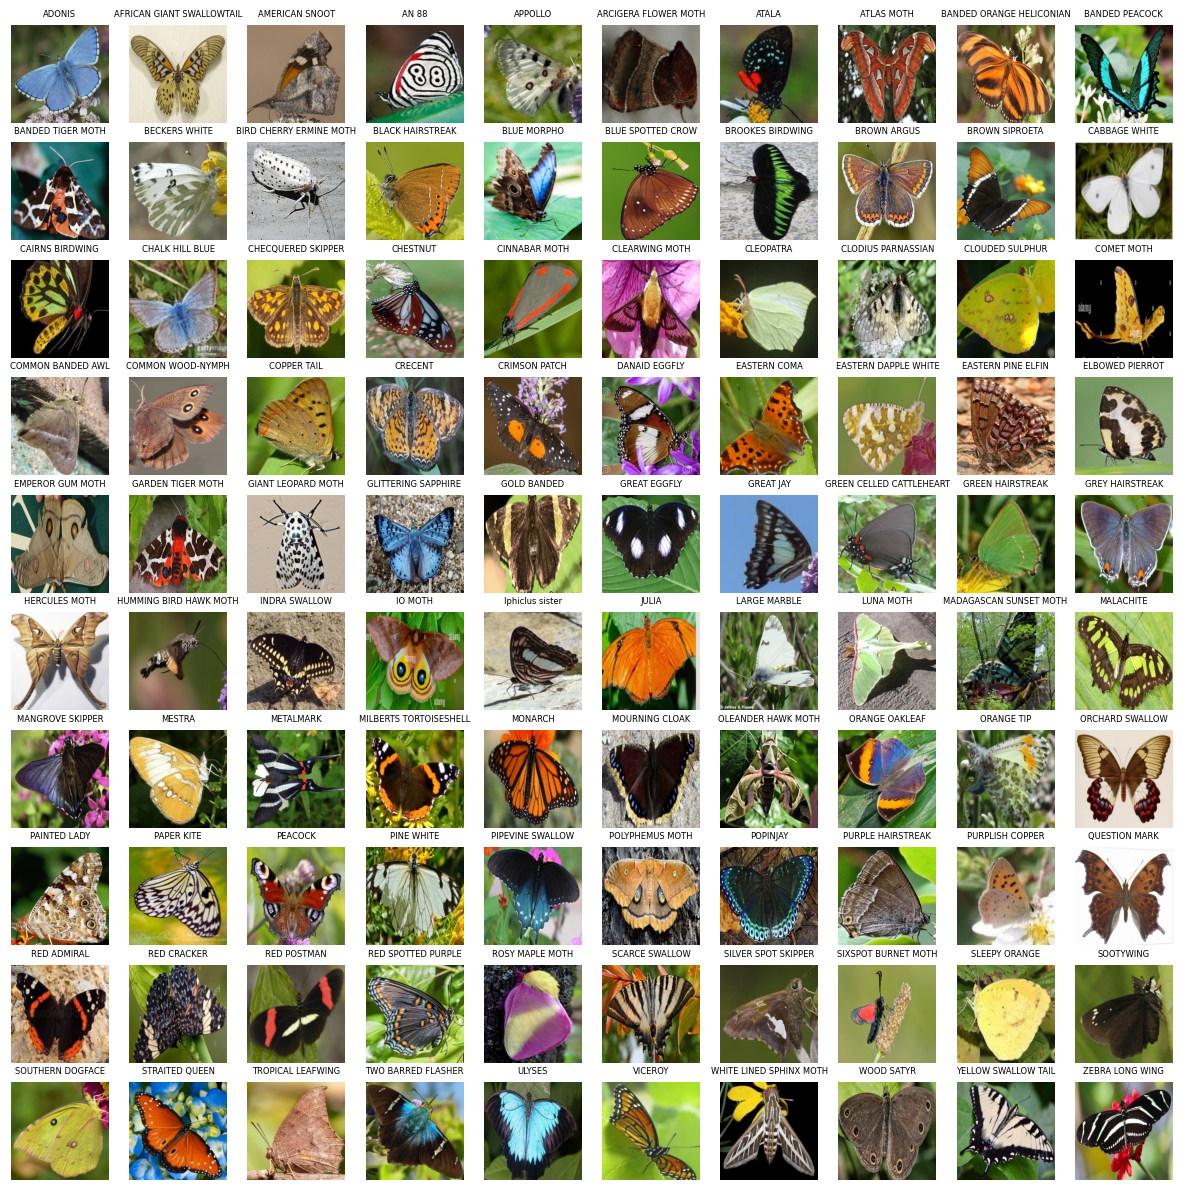

In [13]:
# Load the images
images = [plt.imread(img) for img in train_cat.rand_file]

fig, axs = plt.subplots(10, 10, figsize=(15, 15))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(train_cat.cat[i], fontsize=6)
    ax.axis("off")

plt.savefig('different_categories.png')
plt.show()

## Image size

In [16]:
file_zise = set()
for f in train_cat.rand_file:
    file_zise.add(tf.keras.utils.img_to_array(tf.keras.utils.load_img(f)).shape)

file_zise    

{(224, 224, 3)}

All images are of same size 224 * 224 * 3

# Model

In [2]:
train = "./train/"
val = "./valid/"
test = "./test/"

In [3]:
# find best validation model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=False)

Rather than training CNN from scratch we can leverage pre-trained model and do trasnfer learning. In this scenario we are using pre-trained resnet-50 model

## Resnet50 model

In [32]:
# Load the ResNet50 model
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [33]:
# Freeze the layers of the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False

In [34]:
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(100, activation='softmax')(x)

In [35]:
model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model train with Dropout

In [37]:
# playing around with extreme cases of the augmentation to identify wht works best
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [38]:
train_gen = train_data_gen.flow_from_directory(directory=train, target_size=(224,224), batch_size=32, shuffle=True)

Found 12639 images belonging to 100 classes.


In [39]:
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [40]:
valid_gen =  val_data_gen.flow_from_directory(directory=val, target_size=(224,224), batch_size=32, shuffle=False)

Found 500 images belonging to 100 classes.


In [41]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/20
395/395 [==============================] - 82s 202ms/step - loss: 1.9707 - accuracy: 0.4979 - val_loss: 0.5939 - val_accuracy: 0.8200
Epoch 2/20
395/395 [==============================] - 77s 196ms/step - loss: 0.7235 - accuracy: 0.7872 - val_loss: 0.3664 - val_accuracy: 0.8900
Epoch 3/20
395/395 [==============================] - 77s 196ms/step - loss: 0.4999 - accuracy: 0.8506 - val_loss: 0.4537 - val_accuracy: 0.8600
Epoch 4/20
395/395 [==============================] - 78s 196ms/step - loss: 0.4065 - accuracy: 0.8766 - val_loss: 0.3132 - val_accuracy: 0.9120
Epoch 5/20
395/395 [==============================] - 77s 196ms/step - loss: 0.3395 - accuracy: 0.8953 - val_loss: 0.3176 - val_accuracy: 0.9260
Epoch 6/20
395/395 [==============================] - 77s 195ms/step - loss: 0.3003 - accuracy: 0.9077 - val_loss: 0.3174 - val_accuracy: 0.9180
Epoch 7/20
395/395 [==============================] - 77s 194ms/step - loss: 0.2645 - accuracy: 0.9184 - val_loss: 0.3018 - val_ac

In [43]:
model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1618 - accuracy: 0.9566 - val_loss: 0.4122 - val_accuracy: 0.9260
Epoch 2/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1481 - accuracy: 0.9588 - val_loss: 0.4013 - val_accuracy: 0.9340
Epoch 3/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1457 - accuracy: 0.9600 - val_loss: 0.4222 - val_accuracy: 0.9380
Epoch 4/10
395/395 [==============================] - 77s 195ms/step - loss: 0.1280 - accuracy: 0.9661 - val_loss: 0.3374 - val_accuracy: 0.9400
Epoch 5/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1478 - accuracy: 0.9590 - val_loss: 0.5330 - val_accuracy: 0.9140
Epoch 6/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1430 - accuracy: 0.9627 - val_loss: 0.4008 - val_accuracy: 0.9400
Epoch 7/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1131 - accuracy: 0.9706 - val_loss: 0.4544 - val_ac

Best model had validation accuracy of 94%

# Model train with Augmentation

Here we can perform image augmentation to avoid overfitting and further train the best model stored previously

## Load previous best model

In [44]:
model = tf.keras.models.load_model('./best_model_dropout.h5')

In [48]:
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [49]:
valid_gen =  val_data_gen.flow_from_directory(directory=val, target_size=(224,224), batch_size=32, shuffle=False)

Found 500 images belonging to 100 classes.


In [50]:
model.evaluate(valid_gen)

16/16 [==============================] - 3s 178ms/step - loss: 0.2982 - accuracy: 0.9400


[0.2982429563999176, 0.9399999976158142]

## Generators

In [53]:
# playing around with extreme cases of the augmentation to identify wht works best
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=360,  # image can be any rotation
    width_shift_range=0.025,  # in most images subject is at the center, hence a lower shift
    height_shift_range=0.025, # in most images subject is at the center, hence a lower shift
    shear_range=5,
    zoom_range=[0.95, 1.5]
    # no flipping since rotation is 360
)

In [54]:
train_gen = train_data_gen.flow_from_directory(directory=train, target_size=(224,224), batch_size=32, shuffle=True)

Found 12639 images belonging to 100 classes.


## Train

In [55]:
model.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/5
395/395 [==============================] - 137s 342ms/step - loss: 0.9742 - accuracy: 0.7437 - val_loss: 0.3044 - val_accuracy: 0.9240
Epoch 2/5
395/395 [==============================] - 139s 352ms/step - loss: 0.7126 - accuracy: 0.8056 - val_loss: 0.2967 - val_accuracy: 0.9200
Epoch 3/5
395/395 [==============================] - 146s 368ms/step - loss: 0.5934 - accuracy: 0.8301 - val_loss: 0.2944 - val_accuracy: 0.9100
Epoch 4/5
395/395 [==============================] - 131s 332ms/step - loss: 0.5478 - accuracy: 0.8479 - val_loss: 0.2850 - val_accuracy: 0.9360
Epoch 5/5
395/395 [==============================] - 134s 340ms/step - loss: 0.5089 - accuracy: 0.8560 - val_loss: 0.3450 - val_accuracy: 0.9120


In [56]:
model.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/5
395/395 [==============================] - 132s 333ms/step - loss: 0.4859 - accuracy: 0.8623 - val_loss: 0.2374 - val_accuracy: 0.9400
Epoch 2/5
395/395 [==============================] - 133s 337ms/step - loss: 0.4821 - accuracy: 0.8591 - val_loss: 0.3132 - val_accuracy: 0.9160
Epoch 3/5
395/395 [==============================] - 141s 357ms/step - loss: 0.4448 - accuracy: 0.8726 - val_loss: 0.3116 - val_accuracy: 0.9280
Epoch 4/5
395/395 [==============================] - 147s 371ms/step - loss: 0.4443 - accuracy: 0.8687 - val_loss: 0.3395 - val_accuracy: 0.9040
Epoch 5/5
395/395 [==============================] - 160s 406ms/step - loss: 0.4597 - accuracy: 0.8737 - val_loss: 0.2824 - val_accuracy: 0.9280


In [57]:
model.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/5
395/395 [==============================] - 151s 383ms/step - loss: 0.4108 - accuracy: 0.8827 - val_loss: 0.3197 - val_accuracy: 0.9120
Epoch 2/5
395/395 [==============================] - 139s 353ms/step - loss: 0.3988 - accuracy: 0.8865 - val_loss: 0.3115 - val_accuracy: 0.9380
Epoch 3/5
395/395 [==============================] - 137s 346ms/step - loss: 0.4197 - accuracy: 0.8748 - val_loss: 0.2988 - val_accuracy: 0.9240
Epoch 4/5
395/395 [==============================] - 130s 329ms/step - loss: 0.3966 - accuracy: 0.8873 - val_loss: 0.2981 - val_accuracy: 0.9240
Epoch 5/5
395/395 [==============================] - 127s 322ms/step - loss: 0.4047 - accuracy: 0.8842 - val_loss: 0.3105 - val_accuracy: 0.9320


In [58]:
model.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/5
395/395 [==============================] - 135s 342ms/step - loss: 0.4055 - accuracy: 0.8861 - val_loss: 0.3038 - val_accuracy: 0.9260
Epoch 2/5
395/395 [==============================] - 142s 360ms/step - loss: 0.3791 - accuracy: 0.8885 - val_loss: 0.3020 - val_accuracy: 0.9240
Epoch 3/5
395/395 [==============================] - 141s 358ms/step - loss: 0.3838 - accuracy: 0.8926 - val_loss: 0.3471 - val_accuracy: 0.9180
Epoch 4/5
395/395 [==============================] - 132s 333ms/step - loss: 0.3728 - accuracy: 0.8944 - val_loss: 0.3297 - val_accuracy: 0.9340
Epoch 5/5
395/395 [==============================] - 132s 335ms/step - loss: 0.3715 - accuracy: 0.8975 - val_loss: 0.3302 - val_accuracy: 0.9180


Training accuracy started to hover around 88-89%. Best validation accuracy remained at 94%

# Training model with fine tuning

## Load the previous best model

In [12]:
model = tf.keras.models.load_model('./best_model_dropout.h5')

In [13]:
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [14]:
valid_gen =  val_data_gen.flow_from_directory(directory=val, target_size=(224,224), batch_size=32, shuffle=False)

Found 500 images belonging to 100 classes.


In [15]:
model.evaluate(valid_gen)

16/16 [==============================] - 4s 178ms/step - loss: 0.2982 - accuracy: 0.9400


[0.2982429563999176, 0.9399999976158142]

## Train

Fine tune from **7 * 7 convolution** layers

In [18]:
for i, ly in enumerate(model.layers):
    if ly.name == 'conv5_block1_1_conv':
        print(i)
        break

143


In [19]:
for ly in model.layers[143:]:
    ly.trainable = True

In [20]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [21]:
train_gen = train_data_gen.flow_from_directory(directory=train, target_size=(224,224), batch_size=32, shuffle=True)

Found 12639 images belonging to 100 classes.


In [22]:
model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/10
395/395 [==============================] - 79s 195ms/step - loss: 0.2076 - accuracy: 0.9377 - val_loss: 0.4113 - val_accuracy: 0.9100
Epoch 2/10
395/395 [==============================] - 76s 193ms/step - loss: 0.1882 - accuracy: 0.9439 - val_loss: 0.3520 - val_accuracy: 0.9240
Epoch 3/10
395/395 [==============================] - 76s 193ms/step - loss: 0.1866 - accuracy: 0.9458 - val_loss: 0.3846 - val_accuracy: 0.9400
Epoch 4/10
395/395 [==============================] - 76s 193ms/step - loss: 0.1653 - accuracy: 0.9495 - val_loss: 0.3729 - val_accuracy: 0.9240
Epoch 5/10
395/395 [==============================] - 77s 194ms/step - loss: 0.1559 - accuracy: 0.9549 - val_loss: 0.3238 - val_accuracy: 0.9440
Epoch 6/10
395/395 [==============================] - 76s 193ms/step - loss: 0.1569 - accuracy: 0.9537 - val_loss: 0.3590 - val_accuracy: 0.9320
Epoch 7/10
395/395 [==============================] - 76s 193ms/step - loss: 0.1615 - accuracy: 0.9547 - val_loss: 0.3460 - val_ac

In [23]:
model.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[checkpoint])

Epoch 1/5
395/395 [==============================] - 76s 193ms/step - loss: 0.1544 - accuracy: 0.9594 - val_loss: 0.4117 - val_accuracy: 0.9280
Epoch 2/5
395/395 [==============================] - 76s 193ms/step - loss: 0.1471 - accuracy: 0.9604 - val_loss: 0.4234 - val_accuracy: 0.9300
Epoch 3/5
395/395 [==============================] - 76s 193ms/step - loss: 0.1221 - accuracy: 0.9667 - val_loss: 0.5044 - val_accuracy: 0.9300
Epoch 4/5
395/395 [==============================] - 76s 193ms/step - loss: 0.1461 - accuracy: 0.9613 - val_loss: 0.4340 - val_accuracy: 0.9320
Epoch 5/5
395/395 [==============================] - 76s 193ms/step - loss: 0.1362 - accuracy: 0.9633 - val_loss: 0.5058 - val_accuracy: 0.9220


Validation accuracy improved to 94.4%

# Error analysis

## Load the previous best model

In [24]:
model = tf.keras.models.load_model('./best_model_fine_tune.h5')

In [25]:
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [26]:
valid_gen =  val_data_gen.flow_from_directory(directory=val, target_size=(224,224), batch_size=32, shuffle=False)

Found 500 images belonging to 100 classes.


In [27]:
model.evaluate(valid_gen)

16/16 [==============================] - 4s 178ms/step - loss: 0.3238 - accuracy: 0.9440


[0.32375699281692505, 0.9440000057220459]

## Least precise predicted classes

In [28]:
predictions = model.predict(valid_gen)

16/16 [==============================] - 4s 179ms/step


In [29]:
predict_cls = np.argmax(predictions, axis=1)

In [30]:
true_lables = np.repeat(np.arange(100), 5)

In [31]:
# precision for each class
cls_precision = np.diag(confusion_matrix(true_lables, predict_cls)) / confusion_matrix(true_lables, predict_cls).sum(axis=0)

In [33]:
np.where(cls_precision == cls_precision.min())

(array([90], dtype=int64),)

Categories **90** predicted classes have least precision

In [35]:
# predicted as class 90
# seems class 28 gets mixed up with cls 90
true_lables[predict_cls == 90]

array([28, 28, 88, 90, 90, 90, 90])

In [45]:
np.where(predict_cls == 90)

(array([143, 144, 441, 450, 451, 452, 454], dtype=int64),)

In [36]:
index_to_class = {v:k for k,v in valid_gen.class_indices.items()}

In [37]:
with open('index_to_class.pickle', 'wb') as f:
    pickle.dump(index_to_class, f)

In [38]:
print(f"cls {index_to_class[28]} gets mistaken with cls {index_to_class[90]}")

cls CLOUDED SULPHUR gets mistaken with cls SOUTHERN DOGFACE


#### Explore validation set examples for class 28 vs 90 mix up 

In [48]:
# Load the images
def plot_grid(j, k=5, size=(15, 6)):
    fig, axs = plt.subplots(1, k, figsize=size)

    for i, ax in enumerate(axs.flat):
        ax.imshow(plt.imread( valid_gen.filepaths[j]))
        ax.set_title(index_to_class[valid_gen.classes[j]], fontsize=6)
        ax.axis("off")
        j += 1
    
    plt.show()

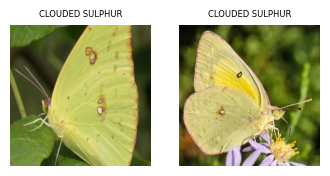

In [52]:
# miss classified CLOUDED SULPHUR
plot_grid(143, 2, (4,3))

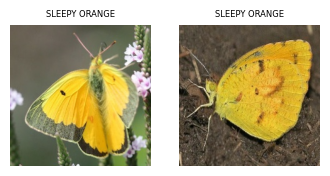

In [56]:
# miss classified SLEEPY ORANGE
# ONLY MISS CLASSIFIED THE FIRST IMAGE HERE 
plot_grid(441, 2, (4,3))

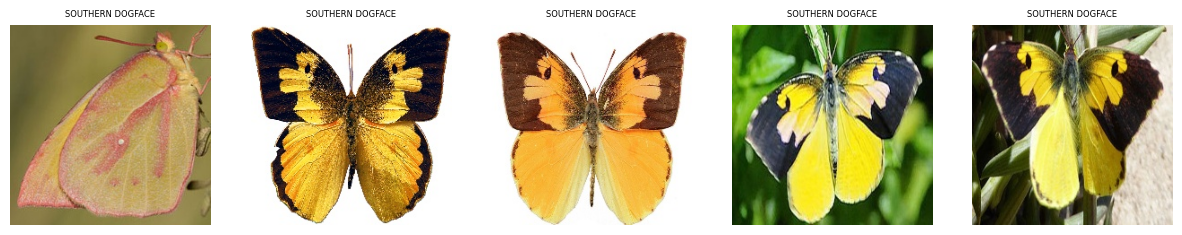

In [43]:
plot_grid(90*5)

Looking at miss classified CLOUD SULPHUR images, both images look very similar to the first image of SOUTHERN DOG FACE. With enough such low quality images in the training dataset for SOUTHERN DOG FACE, this can cause erroneous classfication at testing.

For the miss classified SLEEPY ORANGE, we can see how it has similar darker pattern in the boundary of the wings to that of SOUTHERN DOG FACE, possibly causing the miss classifcation.

# Test set inference

In [57]:
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [58]:
test_gen =  test_data_gen.flow_from_directory(directory=test, target_size=(224,224), batch_size=32, shuffle=False)

Found 500 images belonging to 100 classes.


In [59]:
model.evaluate(test_gen)

16/16 [==============================] - 3s 178ms/step - loss: 0.2690 - accuracy: 0.9480


[0.26895591616630554, 0.9480000138282776]

Test set accuracy observed was 94.8%

In [60]:
for ly in model.layers:
    ly.trainable = False

In [61]:
model.save('final_model.h5')

# Refferences

## Training in GPU

https://www.tensorflow.org/install/pip#windows-wsl2_1

https://www.codingforentrepreneurs.com/blog/install-tensorflow-gpu-windows-cuda-cudnn/